In [1]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os,random, math, psutil, pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold

import json

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import gc

pd.set_option('max_columns', 100)

In [2]:
train = pd.read_pickle('../data/interim/train.pkl')
test = pd.read_pickle('../data/interim/test.pkl')
meter_dict = {0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}

# 1. Features selection

In [3]:
cols_to_drop = ['sea_level_pressure', 'wind_direction']
train = train.drop(cols_to_drop, axis=1)

# 2. Imputing

In [4]:
def impute():
    global train
    # list columns with missing values
    cols_missing = list(train.columns[train.count()<len(train)])
    
    print('Columns that have missing values:', cols_missing)
    
    # use linear interpolate forward
    train['air_temperature'] = train['air_temperature'].interpolate(method='linear', limit_direction='forward', axis=0)
    train['air_temperature'] = train['air_temperature'].interpolate(method='pad', axis=0)

    # check
    if train.air_temperature.isnull().sum() == 0:
        print('The air_temperature is fully filled now.')
    
    from sklearn.impute import SimpleImputer
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    train[cols_missing] = imp_mean.fit_transform(train[cols_missing])
    if train.isnull().sum().sum() == 0:
        print('Successfully imputed by SimpleImputer!')
impute()

Columns that have missing values: ['year_built', 'floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'wind_speed']
The air_temperature is fully filled now.
Successfully imputed by SimpleImputer!


## 3. Feature engineering

In [5]:
def feture_engineering():
    
    global train
    
    # encode categorical
    # le = LabelEncoder()
    # train['primary_use'] = le.fit_transform(train['primary_use']).astype(np.int8)

    # year_built to age
    # train['age'] = train['year_built'].max() - train['year_built'] + 1

    ## Add day  and week of year #######################

    train['hour'] = train['timestamp'].dt.hour.astype(np.int8)
    #train['dayofweek'] = train['timestamp'].dt.dayofweek.astype(np.int8)
    #train['dayofmonth'] = train['timestamp'].dt.day.astype(np.int8)
    train['dayofyear'] = train['timestamp'].dt.dayofyear.astype(np.int16)
    #train['weekofmonth'] = train['timestamp'].dt.day % 7
    train['weekofyear'] = train['timestamp'].dt.weekofyear.astype(np.int8)
    #train['month'] = train['timestamp'].dt.month.astype(np.int8)

    ## beaufort_scale
    beaufort = [(0, 0, 0.3), (1, 0.3, 1.6), (2, 1.6, 3.4), (3, 3.4, 5.5), (4, 5.5, 8), (5, 8, 10.8), (6, 10.8, 13.9), 
              (7, 13.9, 17.2), (8, 17.2, 20.8), (9, 20.8, 24.5), (10, 24.5, 28.5), (11, 28.5, 33), (12, 33, 200)]
    for item in beaufort:
        train.loc[(train['wind_speed']>=item[1]) & (train['wind_speed']<item[2]), 'beaufort_scale'] = item[0]    

    ## change dtypes to save memory
    train["meter"] = train['meter'].astype(np.int8)
    train["site_id"] = train['site_id'].astype(np.int8)
    
    train = pd.get_dummies(train, prefix_sep="_")
    
feture_engineering()

# 4. Make X and y

In [6]:
def make_X_y():    
    global X, y
    X = train.drop(['meter_reading', 'timestamp'], axis=1)
    y = np.log1p(train[['meter_reading']])
    return X, y
X, y = make_X_y()

# 5. Light gradient boosting

In [22]:
models = []

kf = KFold(n_splits=5, shuffle=False, random_state=777)

for train_index, test_index in kf.split(X):
    
    # split train and test set
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]

    num_train, num_feature = X_train.shape

    # create dataset for lightgbm
    # set free_raw_data=False to reuse data
    lgb_train = lgb.Dataset(X_train, y_train, weight=None, free_raw_data=False)
    lgb_eval = lgb.Dataset(X_test, y_test, weight=None, free_raw_data=False)

    # specify your configurations as a dict
    params = {
              "objective": "regression",
              "boosting": "gbdt",
              "num_leaves": 1280,
              "learning_rate": 0.1,
              "feature_fraction": 0.85,
              "reg_lambda": 2,
              "metric": "rmse"}

    model = lgb.train(params,
                      lgb_train,
                      num_boost_round=70,
                      valid_sets=lgb_train,  # eval training data
                      categorical_feature="auto",
                      verbose_eval=25, 
                      early_stopping_rounds=50)
    
    models.append(model)

Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.860704
[50]	training's rmse: 0.701492
Did not meet early stopping. Best iteration is:
[70]	training's rmse: 0.650349
Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.869026
[50]	training's rmse: 0.702153
Did not meet early stopping. Best iteration is:
[70]	training's rmse: 0.645622
Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.863216
[50]	training's rmse: 0.701621
Did not meet early stopping. Best iteration is:
[70]	training's rmse: 0.646897
Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.845592
[50]	training's rmse: 0.689101
Did not meet early stopping. Best iteration is:
[70]	training's rmse: 0.635878
Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.8551
[50]	training's rmse: 0.694836
Did not meet early stopping. Best iteration is:
[70]	training's rmse: 0

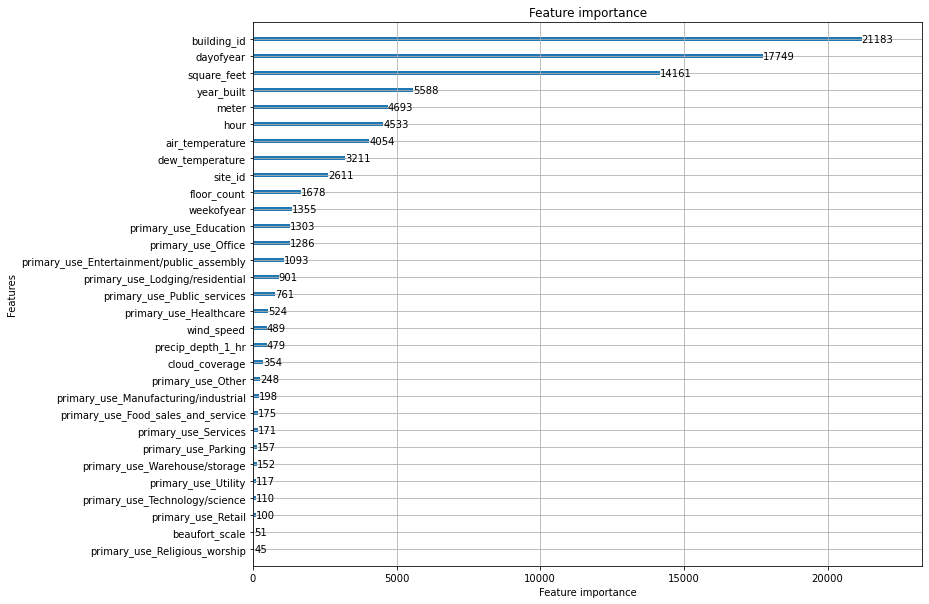

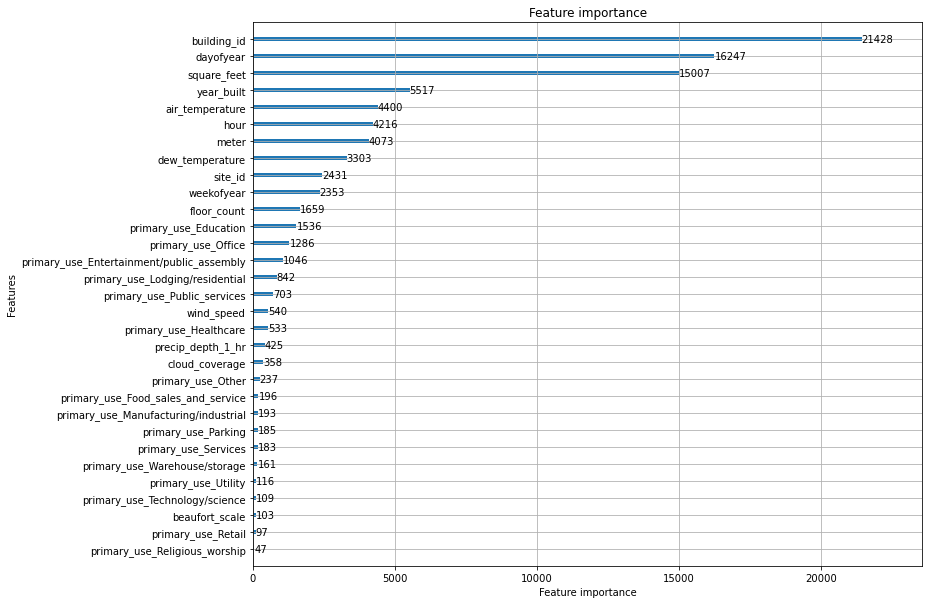

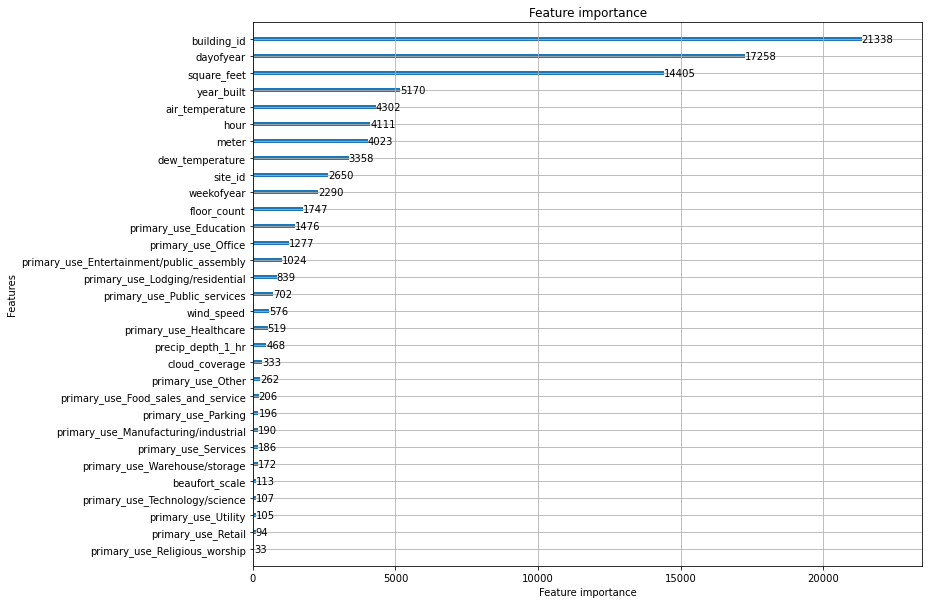

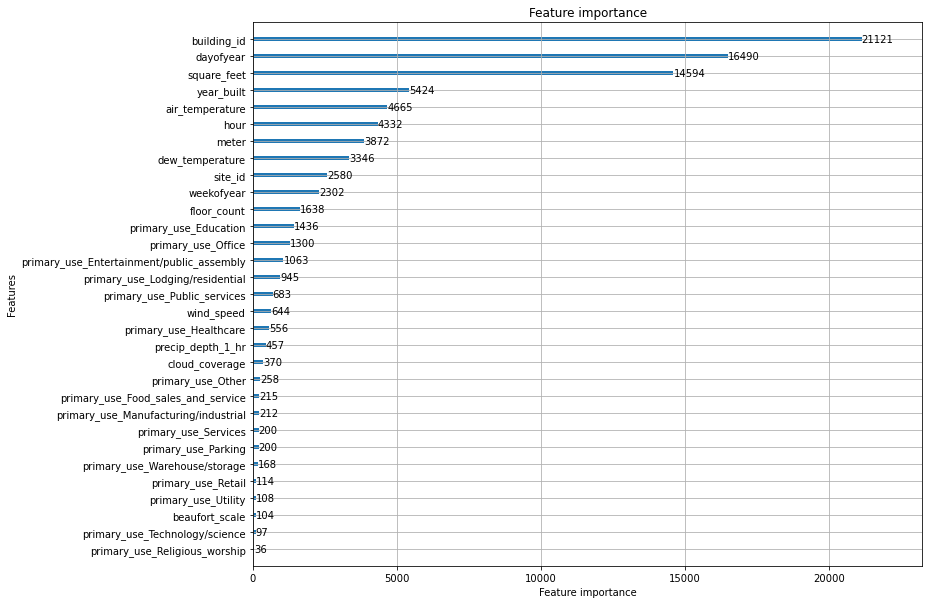

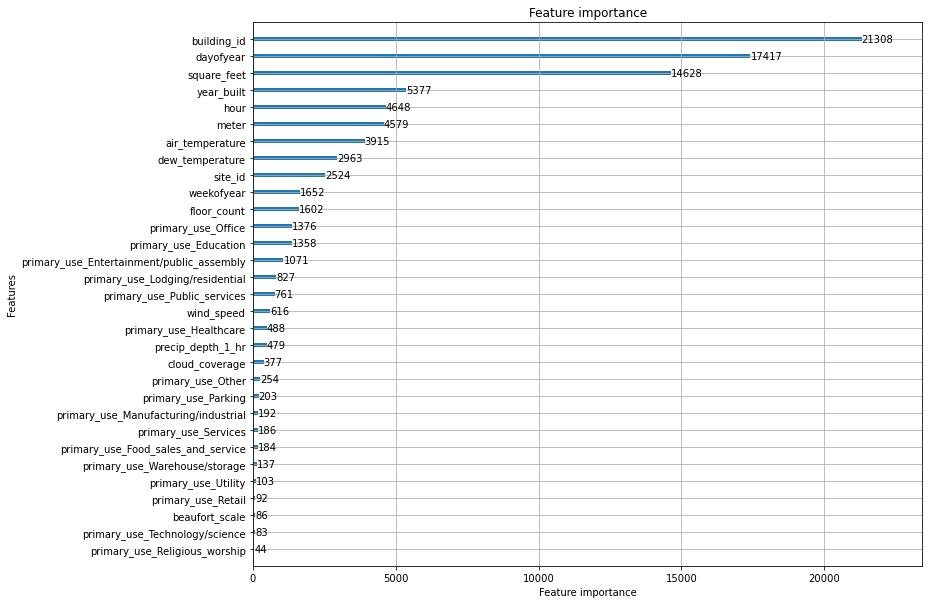

In [24]:
for model in models:
    fig, axes = plt.subplots(figsize=(12, 10))
    lgb.plot_importance(model, ax=axes)
    plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [ ]:
def print_scores():
    scores_avg = {}
    for model, score_list in scores.items():
        print(model)
        for individual_score in score_list:
            print(individual_score)
        scores_avg[model] = np.mean(score_list)
        print(f'Average: {scores_avg[model]} \n')

    sorted_scores = sorted(scores_avg.items(), key=lambda score: score[1], reverse=True)

    print('Scores ranking:')
    for model, avg in sorted_scores:
        print(model, avg)

In [ ]:
scores = {} # holde cross validation scores
def model(choice = 'lr'):
    
    if choice == 'lr':
        model = LinearRegression()
    if choice == 'ridge':
        model = Ridge(random_state=42)
    if choice == 'lasso':
        model = Lasso(random_state=42)
    if choice == 'trees':        
        model = DecisionTreeRegressor(max_depth=6, random_state=42)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=21)
    
    cross_val_scores= cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

    scores[choice] = cross_val_scores
    print(cross_val_scores)
    print('Average: ', np.mean(cross_val_scores))

#### zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz
# lgbm 2

### Preprocessing before modelling

In [ ]:
Xy = train.drop('timestamp', axis=1)
X = Xy.drop('meter_reading', axis=1)
y = Xy[['meter_reading']]

In [ ]:
%%time
categorical_X = ["building_id", "site_id", "meter", "primary_use"]
# categorical_X = ["building_id", "site_id", "meter", "primary_use", "is_holiday", "weekend"]
params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 1280,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse",
}

nround=70
kf = KFold(n_splits=3)
models = []
for train_index,test_index in kf.split(X):
    train_X = X.loc[train_index]
    train_y = y.loc[train_index]
    
    test_X = X.loc[test_index]
    test_y = y.loc[test_index]
    
    d_training = lgb.Dataset(train_X, label=train_y, categorical_feature=categorical_X, free_raw_data=False)
    d_test = lgb.Dataset(test_X, label=test_y,categorical_feature=categorical_X, free_raw_data=False)
    
    model = lgb.train(params, train_set=d_training, num_boost_round=nround, valid_sets=[d_training,d_test], verbose_eval=25, early_stopping_rounds=50)
    models.append(model)
    del train_X, train_y, test_X, test_y, d_training, d_test
    gc.collect()
# Wall time: 9min 17s

In [ ]:
#########################################3

# lgbm 3

### Preprocessing before modelling

In [ ]:
Xy = train.drop('timestamp', axis=1)
X = Xy.drop('meter_reading', axis=1)
y = Xy[['meter_reading']]

In [ ]:
y = np.log1p(y["meter_reading"])

In [ ]:
%%time
categorical_X = ["building_id", "site_id", "meter", "primary_use"]
# categorical_X = ["building_id", "site_id", "meter", "primary_use", "is_holiday", "weekend"]
params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 1280,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse",
}

nround=70
kf = KFold(n_splits=3)
models = []
for train_index,test_index in kf.split(X):
    train_X = X.loc[train_index]
    train_y = y.loc[train_index]
    
    test_X = X.loc[test_index]
    test_y = y.loc[test_index]
    
    d_training = lgb.Dataset(train_X, label=train_y, categorical_feature=categorical_X, free_raw_data=False)
    d_test = lgb.Dataset(test_X, label=test_y,categorical_feature=categorical_X, free_raw_data=False)
    
    model = lgb.train(params, train_set=d_training, num_boost_round=nround, valid_sets=[d_training,d_test], verbose_eval=25, early_stopping_rounds=50)
    models.append(model)
    del train_X, train_y, test_X, test_y, d_training, d_test
    gc.collect()
# Wall time: 

## Important Features

# ================backup================

## average_imputation

In [ ]:
def average_imputation(df, column_name):
    imputation = df.groupby(['timestamp'])[column_name].mean()
    _ = df.loc[df[column_name].isnull(), column_name]
    _  = _.apply(lambda x: imputation[df['timestamp'][x.index]].values)
    del imputation
    return df

In [ ]:
train = average_imputation(train, 'wind_speed')
train = average_imputation(train, 'wind_direction')

In [ ]:

%%time
fig, axes = plt.subplots(1, 1, figsize=(20, 6))
sns.barplot(x='primary_use', y='meter_reading', data=train)

---------------------------------------------------------------------------
KeyboardInterrupt                         Traceback (most recent call last)
<timed exec> in <module>()

~\Anaconda3\lib\site-packages\seaborn\categorical.py in barplot(x, y, hue, data, order, hue_order, estimator, ci, n_boot, units, seed, orient, color, palette, saturation, errcolor, errwidth, capsize, dodge, ax, **kwargs)
   3148                           estimator, ci, n_boot, units, seed,
   3149                           orient, color, palette, saturation,
-> 3150                           errcolor, errwidth, capsize, dodge)
   3151 

In [ ]:
%%time
fig, axes = plt.subplots(1, 1, figsize=(35, 12))
sns.boxplot(x='primary_use', y='meter_reading', data=train[(train.timestamp.dt.month==1) & (train.meter==0)], showfliers=False);

## wind direction

In [ ]:
# Convert wind direction into categorical feature. We can split 360 degrees into 16-wind compass rose. 
# See this: https://en.wikipedia.org/wiki/Points_of_the_compass#16-wind_compass_rose
def degToCompass(num):
    val=int((num/22.5))
    arr=[i for i in range(0,16)]
    return arr[(val % 16)]

In [ ]:
train['wind_direction'] = train['wind_direction'].apply(degToCompass)

In [ ]:
train.groupby('timestamp')['meter_reading'].sum()